In [ ]:
countries_charts = get_countries_charts()
countries_charts


,country,date,rank,streams,id,iso_alpha3,iso_alpha2,geo_region,geo_subregion
0,Argentina,2017-01-01,1,253019.0,6mICuAdrwEjh6Y6lroV2Kg,ARG,AR,Americas,Latin America and the Caribbean
1,Argentina,2017-01-01,2,223988.0,7DM4BPaS7uofFul3ywMe46,ARG,AR,Americas,Latin America and the Caribbean
2,Argentina,2017-01-01,3,210943.0,3AEZUABDXNtecAOSC1qTfo,ARG,AR,Americas,Latin America and the Caribbean
3,Argentina,2017-01-01,4,173865.0,6rQSrBHf7HlZjtcMZ4S4bO,ARG,AR,Americas,Latin America and the Caribbean
4,Argentina,2017-01-01,5,153956.0,58IL315gMSTD37DOZPJ2hf,ARG,AR,Americas,Latin America and the Caribbean
...,...,...,...,...,...,...,...,...,...
4472525,Uruguay,2021-08-13,25,11431.0,4aXicRG47bBEcKXlDaSRwW,URY,UY,Americas,Latin America and the Caribbean
4472526,Uruguay,2021-08-13,27,10946.0,43qcs9NpJhDxtG91zxFkj7,URY,UY,Americas,Latin America and the Caribbean
4472527,Uruguay,2021-08-13,33,9994.0,4M4DTyLupKvbJKlE4I4EYq,URY,UY,Americas,Latin America and the Caribbean
4472528,Uruguay,2021-08-13,35,9251.0,5jzEwSyyymBlf1fa1o39T2,URY,UY,Americas,Latin America and the Caribbean


In [ ]:
def get_tracks_for_region(region):
    return countries_charts.loc[countries_charts["geo_region"] == region, "id"].reset_index(drop=True).drop_duplicates()

def get_tracks_for_regions(regions):
    return pd.concat([pd.DataFrame({"region": region, "id": get_tracks_for_region(region)}) for region in regions], ignore_index=True)

tracks_by_region = get_tracks_for_regions(countries_charts["geo_region"].unique())
tracks_by_region

,region,id
0,Americas,6mICuAdrwEjh6Y6lroV2Kg
1,Americas,7DM4BPaS7uofFul3ywMe46
2,Americas,3AEZUABDXNtecAOSC1qTfo
3,Americas,6rQSrBHf7HlZjtcMZ4S4bO
4,Americas,58IL315gMSTD37DOZPJ2hf
...,...,...
40584,Asia,4FiDkc2woxfDbfCoSqx6pq
40585,Asia,7C4azcFK7GaKT75dhHYgVM
40586,Asia,0uUUq6JFqKK6Z6YtSERs9V
40587,Asia,16wVY2lWuqBjjPrpTa6KSN


In [ ]:
tracks_by_region[tracks_by_region.duplicated(keep=False, subset="id")].sort_values(by="id")

,region,id
7866,Oceania,000xQL6tZNLJzIrtIgxqSl
2676,Americas,000xQL6tZNLJzIrtIgxqSl
13892,Europe,000xQL6tZNLJzIrtIgxqSl
34626,Asia,000xQL6tZNLJzIrtIgxqSl
3172,Americas,003eoIwxETJujVWmNFMoZy
...,...,...
13879,Europe,7zTx8ePYAmPFQuxP3xlXZn
10066,Europe,7zgqtptZvhf8GEmdsM2vp2
34752,Asia,7zgqtptZvhf8GEmdsM2vp2
7966,Oceania,7zgqtptZvhf8GEmdsM2vp2


In [ ]:
tracks_charting_only_in_one_region = tracks_by_region[~tracks_by_region.duplicated(keep=False, subset="id")].reset_index(drop=True)
tracks_charting_only_in_one_region

,region,id
0,Americas,1MpKZi1zTXpERKwxmOu1PH
1,Americas,1pWYnQIlqxTh5bxuPmTG4E
2,Americas,7IRuf7FrdQvOGs0g9mSNGr
3,Americas,3gEebOzxHpEwElicl1XBy0
4,Americas,0tGAPnTFwRJA6FZgYZ0BAe
...,...,...
30099,Asia,4FiDkc2woxfDbfCoSqx6pq
30100,Asia,7C4azcFK7GaKT75dhHYgVM
30101,Asia,0uUUq6JFqKK6Z6YtSERs9V
30102,Asia,16wVY2lWuqBjjPrpTa6KSN


In [ ]:
tracks_charting_only_in_one_region

,region,id
0,Americas,1MpKZi1zTXpERKwxmOu1PH
1,Americas,1pWYnQIlqxTh5bxuPmTG4E
2,Americas,7IRuf7FrdQvOGs0g9mSNGr
3,Americas,3gEebOzxHpEwElicl1XBy0
4,Americas,0tGAPnTFwRJA6FZgYZ0BAe
...,...,...
30099,Asia,4FiDkc2woxfDbfCoSqx6pq
30100,Asia,7C4azcFK7GaKT75dhHYgVM
30101,Asia,0uUUq6JFqKK6Z6YtSERs9V
30102,Asia,16wVY2lWuqBjjPrpTa6KSN


In [ ]:
region_tracks_features = relevant_track_features.join(tracks_charting_only_in_one_region.set_index("id"), on="id", how="right")
region_tracks_features

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,single_release,region
id,,,,,,,,,,,,,,,,
1MpKZi1zTXpERKwxmOu1PH,False,0.588,0.682,11.0,-7.169,0.0,0.1730,0.08510,0.000027,0.0840,0.937,205.643,195274.0,4.0,True,Americas
1pWYnQIlqxTh5bxuPmTG4E,False,0.780,0.929,11.0,-0.739,0.0,0.0532,0.17100,0.000000,0.0677,0.837,95.012,227693.0,4.0,False,Americas
7IRuf7FrdQvOGs0g9mSNGr,False,0.598,0.917,0.0,-3.455,1.0,0.1590,0.11700,0.000000,0.3980,0.575,180.049,254069.0,4.0,True,Americas
3gEebOzxHpEwElicl1XBy0,False,0.549,0.798,6.0,-4.185,1.0,0.0705,0.12600,0.000000,0.3290,0.905,100.054,199495.0,4.0,True,Americas
0tGAPnTFwRJA6FZgYZ0BAe,False,0.608,0.859,6.0,-5.580,0.0,0.1850,0.11500,0.000000,0.3250,0.800,190.065,190040.0,4.0,True,Americas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4FiDkc2woxfDbfCoSqx6pq,True,0.481,0.515,11.0,-13.273,1.0,0.2850,0.07220,0.000001,0.1570,0.592,139.285,111902.0,4.0,True,Asia
7C4azcFK7GaKT75dhHYgVM,False,0.821,0.735,6.0,-6.383,0.0,0.2200,0.16400,0.000012,0.1950,0.584,110.074,209455.0,4.0,True,Asia
0uUUq6JFqKK6Z6YtSERs9V,False,0.505,0.831,6.0,-5.852,0.0,0.0270,0.00007,0.000342,0.0549,0.588,145.017,352000.0,4.0,True,Asia


In [ ]:
X = region_tracks_features.drop(columns=["region"]).dropna()
y = region_tracks_features.loc[X.index, "region"]

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
X_scaled = pd.DataFrame(MinMaxScaler().fit_transform(X), columns=X.columns, index=X.index)

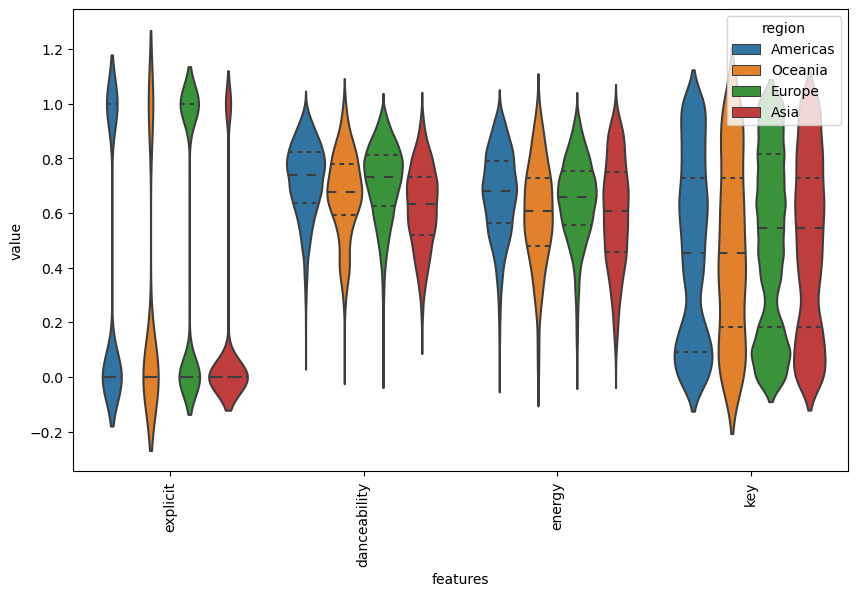

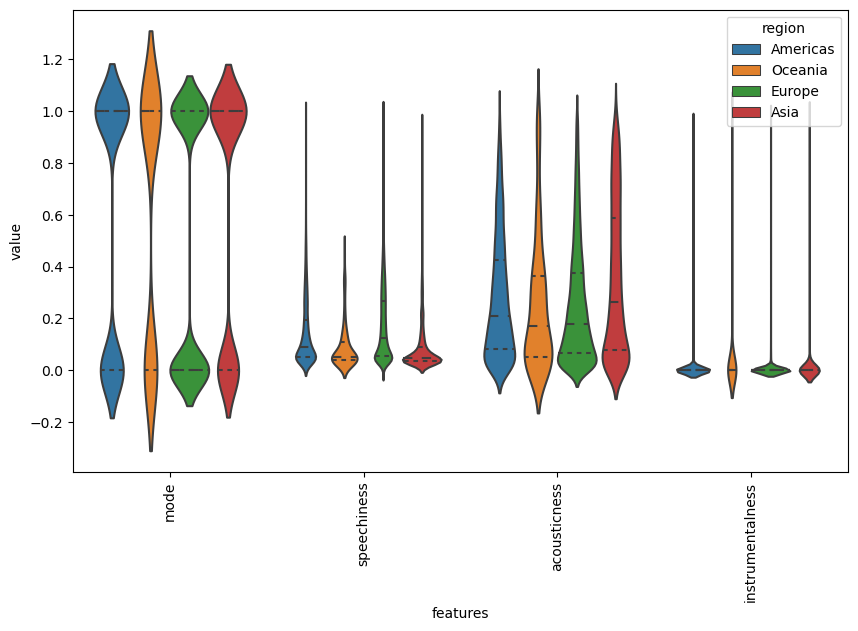

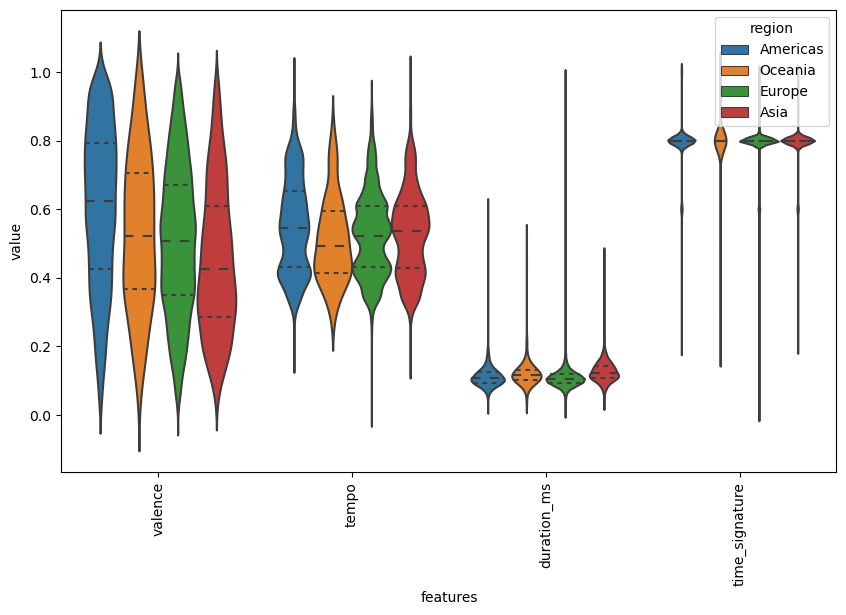

In [ ]:
for i in range(3):
    data = pd.concat([y, X_scaled.iloc[:,i*5:i*5+4]], axis=1)
    data = pd.melt(data,
                   id_vars="region",
                   var_name="features",
                   value_name='value')

    plt.figure(figsize=(10, 6))
    sns.violinplot(x="features", y="value", data=data,
                   hue="region",# compare distributions of values for feature by class (different colors for each of the two classes)
                   #split=True,# split violins (left half distribution of false class, right shows distribution of true)
                   inner="quartile"# show quartiles as lines instead of putting boxplot inside
                   )
    plt.xticks(rotation=90)
    #plt.savefig("plots/violibneplot_normaltransformed.png")
    plt.show()